<a href="https://colab.research.google.com/github/vitorbertelli/linguagens-formais-automatos/blob/main/apresentacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linguagens Formais e Autômatos - Trabalho 1° Bimestre

## FUNÇÕES AUXILIARES

In [12]:
def read_file(file_path: str) -> str:
  with open(file_path, "r") as file:
    content = file.read()
  return content

In [13]:
def arquivo_afd(estados: list, estado_inicial: str, estados_finais: list, transicoes: dict) -> None:
  with open("saida.txt", "w") as file:
    file.write(" ".join(estados) + "\n")
    file.write(estado_inicial + "\n")
    file.write(" ".join(estados_finais) + "\n")
    for estado in transicoes:
      for simbolo in transicoes[estado]:
        file.write(f"{estado} {simbolo} {transicoes[estado][simbolo]}\n")

In [14]:
def reconhecer_palavra(palavra: str, estado_inicial: str, estados_finais: list, transicoes: dict) -> bool:
  estado_atual = estado_inicial
  for simbolo in palavra:
    if estado_atual in transicoes and simbolo in transicoes[estado_atual]:
      estado_atual = transicoes[estado_atual][simbolo]
    else:
      return False
  return estado_atual in estados_finais

In [15]:
def arquivo_resposta(palavras: list, estado_inicial: str, estados_finais: list, transicoes: dict) -> None:
  with open("resposta.txt", "w") as file:
    for palavra in palavras:
      file.write(f"{palavra} {'aceito' if reconhecer_palavra(palavra, estado_inicial, estados_finais, transicoes) else 'não aceito'}\n")

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

def desenhar_automato(estados, estado_inicial, estados_finais, transicoes):
  G = nx.DiGraph()

  for estado in estados:
    G.add_node(estado)

  for estado_atual, transicao in transicoes.items():
    for simbolo, proximo_estado in transicao.items():
      if simbolo == 'h':
        simbolo = 'ε'
      G.add_edge(estado_atual, proximo_estado, label=simbolo)

  pos = nx.spring_layout(G)

  nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)

  edge_labels = nx.get_edge_attributes(G, 'label')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

  plt.text(pos["".join(estado_inicial)][0] - 0.05, pos["".join(estado_inicial)][1] + 0.05, "Inicial", fontsize=12, color="green", fontweight='bold')

  for estado_final in estados_finais:
    nx.draw_networkx_nodes(G, pos, nodelist=[estado_final], node_color="lightblue", node_size=2000, linewidths=3, edgecolors='red')

  plt.show()

## FUNÇÕES DE EXECUÇÃO

In [21]:
# Função que lê o arquivo de entrada e retorna os estados, estado inicial, estados finais e transições do autômato
def separar_arquivo_automato(arquivo_automato: str) -> tuple:
  linhas = arquivo_automato.strip().split("\n") # Divide o arquivo em linhas
  estados = linhas[0].split() # Armazena os estados da primeira linha
  estado_inicial = linhas[1]  # Armazena o estado inicial da segunda linha
  estados_finais = linhas[2].split() # Armazena os estados finais da terceira linha

  transicoes = {} # Inicia um dicionário onde as chaves são os estados e os valores são outros dicionários que representam as transições
  for linha in linhas[3:]:
    estado, simbolo, proximo_estado = linha.split() # Divide a linha em estado, símbolo e próximo estado
    transicoes.setdefault(estado, {}).setdefault(simbolo, set()).add(proximo_estado) # Se o estado não existir no dicionário, cria um novo dicionário. Se o símbolo não existir no dicionário do estado, cria um novo conjunto. Adiciona o próximo estado ao conjunto de estados

  return estados, estado_inicial, estados_finais, transicoes

In [22]:
# Função que calcula o fecho de um estado, ou seja, todos os estados que podem ser alcançados a partir dele por transições vazias
def fechamento(estado: str, transicoes: dict) -> tuple:
  fecho = {estado}
  pilha = [estado]
  while pilha:
    estado_atual = pilha.pop()
    if estado_atual in transicoes and "h" in transicoes[estado_atual]:
      for proximo_estado in transicoes[estado_atual]["h"]:
        if proximo_estado not in fecho:
          fecho.add(proximo_estado)
          pilha.append(proximo_estado)
  return "".join(fecho), fecho # Retorna o fecho como uma string, por exemplo 'q0q1', e como um set

In [23]:
# Função que calcula o conjunto de estados alcançados a partir de um conjunto de estados e um símbolo
def mover(estados: set, simbolo: str, transicoes: dict) -> str:
  proximos_estados = set() # Inicia um conjunto vazio para armazenar os próximos estados alcançados
  for estado in estados:
    if estado in transicoes and simbolo in transicoes[estado]: # Se o estado atual tiver transições para o símbolo
      for proximo_estado in transicoes[estado][simbolo]: # Para cada estado alcançável a partir do estado atual
        fecho_str, fecho_set = fechamento(proximo_estado, transicoes) # Calcula o fecho do estado
        proximos_estados.update(fecho_set) # Adiciona o fecho ao conjunto de próximos estados
  return "".join(proximos_estados), proximos_estados # Retorna os próximos estados como uma string, por exemplo 'q0q1', e como um set

In [24]:

# Função que converte um autômato finito não determinístico em um autômato finito determinístico
def converter_para_afd(estado_inicial: str, estados_finais: list, transicoes: dict) -> tuple:
  # Inicializa as variáveis usadas para a construção do AFD
  afd_estado_inicial, estado_inicial_set = fechamento(estado_inicial, transicoes)
  afd_estados_finais = []
  afd_transicoes = {}
  afd_estados = [afd_estado_inicial]

  pilha_estados = [afd_estado_inicial]
  pilha_estados_set = [estado_inicial_set]
  estados_visitados = []

  # Enquanto houver estados a serem visitados
  while pilha_estados:
    estado_atual = pilha_estados.pop()
    estado_atual_set = pilha_estados_set.pop()
    estados_visitados.append(estado_atual)

    if any(estado_final in estado_atual for estado_final in estados_finais): # Se o estado atual contém um estado final
      afd_estados_finais.append(estado_atual) # Adiciona o estado atual a lista de estados finais do AFD

    for simbolo in {s for t in transicoes.values() for s in t if s != "h"}: # Para cada símbolo do alfabeto que não seja uma transição vazia
      proximo_estado, proximo_estado_set = mover(estado_atual_set, simbolo, transicoes) # Calcula o próximo estado

      if proximo_estado: # Se o próximo estado não for vazio
        if estado_atual not in afd_transicoes: # Se o estado atual não estiver no dicionário de transições do AFD
          afd_transicoes[estado_atual] = {} # Cria um novo dicionário para o estado atual
        afd_transicoes[estado_atual][simbolo] = proximo_estado # Adiciona a transição para o próximo estado

        if proximo_estado not in estados_visitados and proximo_estado not in pilha_estados: # Se o próximo estado não foi visitado e não está na pilha
          afd_estados.append(proximo_estado)
          pilha_estados.append(proximo_estado)
          pilha_estados_set.append(proximo_estado_set)

  return afd_estados, afd_estado_inicial, afd_estados_finais, afd_transicoes # Retorna os estados, estado inicial, estados finais e transições do AFD

In [25]:
def main(caminho_entrada: str, caminho_palavras: str) -> None:
    entrada = read_file(caminho_entrada)
    palavras = read_file(caminho_palavras).split("\n")
    estados, estado_inicial, estados_finais, transicoes = separar_arquivo_automato(entrada)
    afd_estados, afd_estado_inicial, afd_estados_finais, afd_transicoes = converter_para_afd(estado_inicial, estados_finais, transicoes)
    arquivo_afd(afd_estados, afd_estado_inicial, afd_estados_finais, afd_transicoes)
    arquivo_resposta(palavras, afd_estado_inicial, afd_estados_finais, afd_transicoes)
    desenhar_automato(afd_estados, afd_estado_inicial, afd_estados_finais, afd_transicoes)

## EXEMPLO

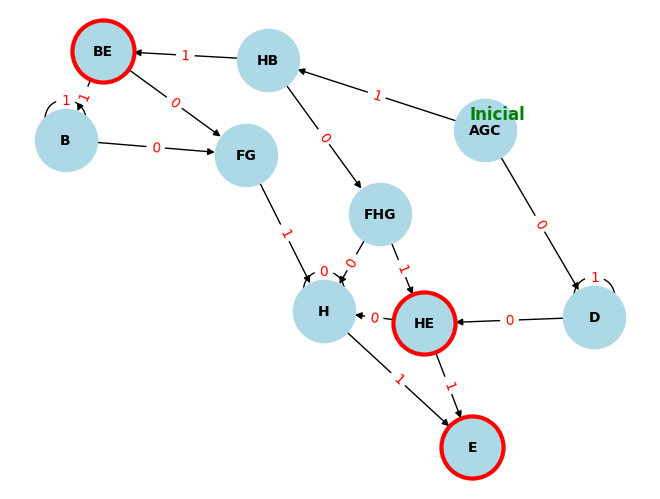

In [26]:
main("entrada.txt", "palavras.txt")